<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/3%20action%20deep%20q%20regularized%20(2)%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!pip install pandas_ta
!pip install tf_agents[reverb]

In [38]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import reverb
import random

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.policies import greedy_policy
from tf_agents.policies.epsilon_greedy_policy import EpsilonGreedyPolicy
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

In [39]:
num_iterations = 2000000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = 3  # @param {type:"integer"}
eval_interval = 10000  # @param {type:"integer"}

In [40]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [41]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


In [42]:
RSI = ta.rsi(close,14,scalar=1)
AROON = ta.aroon(high,low,14,scalar = 1)
AROON_UP = AROON['AROOND_14']
AROON_DOWN = AROON['AROONU_14']
CCI = ta.cci(high,low,close,14)
CCI = CCI.multiply(.001)
CCI = CCI.add(.5)
RVI = ta.rvi(close,high,low,14,scalar=1)
CHANGE = get_relative_change(close,"Change")

sma = ta.sma(close,20,offset = -20)
sma2 = ta.sma(close,30,offset = -20)
DIFF = sma-sma2
DIFF = DIFF/np.std(DIFF)
DIFF.name = 'DIFF'

INDICATORS = pd.concat([CHANGE,RSI,AROON_UP,AROON_DOWN,CCI,RVI,DIFF],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()

change = INDICATORS.pop('Change')
diff = INDICATORS.pop('DIFF')
INDICATORS.pop('index')

INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev
np.set_printoptions(suppress=True)

(93050,)


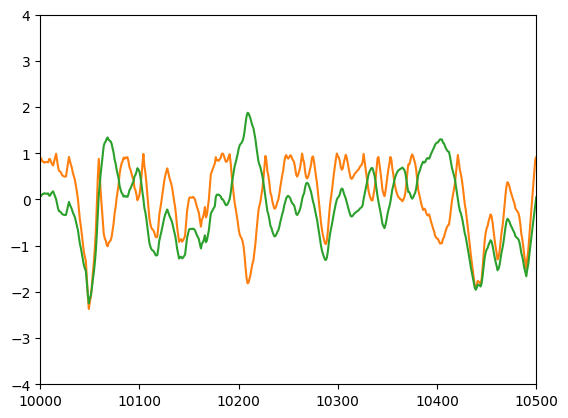

In [43]:
plt.xlim(10000,10500)
plt.ylim(-4,4)
print(diff.shape)
plt.plot(np.cumsum(change))
plt.plot((abs(diff)*-1.5)+1)
plt.plot(diff)

In [44]:
print(INDICATORS)

[[0.3819 1.     0.7143 0.3933 0.8533]
 [0.5244 0.9286 0.6429 0.4226 0.8727]
 [0.4539 0.8571 0.5714 0.3887 0.7506]
 ...
 [0.5281 0.7143 0.0714 0.4894 0.6202]
 [0.5498 0.6429 0.     0.5646 0.6522]
 [0.5714 0.5714 0.     0.6308 0.6745]]


(5400.0, 5500.0)

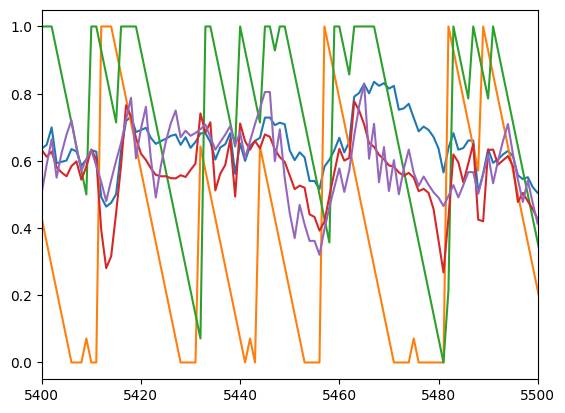

In [45]:
plt.plot(INDICATORS)
plt.xlim(5400,5500)
#print(INDICATORS)

In [46]:
def test_environment(env, num_steps):
    # Reset the environment
    observation = env.reset()

    # Get the upper bound of the action range
    action_spec = env.action_spec().maximum

    # Loop through the time steps and take random actions
    for _ in range(num_steps):
        # Select a random action from the range of valid values
        action = random.randint(0, action_spec)

        # Execute the action and get the next observation, reward, done, and info
        observation, reward, done, info = env.step(action)

        # Print the current time step
        np.set_printoptions(precision=4)
        print(reward,action,info)


In [47]:
max_ep_len = 1000

In [48]:
class TradingEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int64, minimum=0, maximum=3, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(8,), dtype=np.float32, minimum=-100,maximum=100, name='observation')


    self._state = [0,0,0,0,0,0,0,0]
    self._episode_ended = False
    self._count = random.randint(0,60000)
    self._end_ep = self._count+max_ep_len
    self._balance = 0
    self.trade_info = {
    'value': 0,
    'time': 0,
    'direction': 0,
    }


  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):

    self._state = [0,0,0,0,0,0,0,0]
    self._episode_ended = False
    self._count = random.randint(0,60000)
    self._end_ep = self._count+max_ep_len
    self._balance = 0
    self.trade_info = {
    'value': 0,
    'time': 0,
    'direction': 0,
    }

    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    profit = 0
    cur_direction = self.trade_info['direction']
    hold_penelty = 0
    hold_reward = 0


    if action == 0:
      profit = self.trade_info['value']
      self.trade_info['value'] = change[self._count]
      self.trade_info['time'] = 0
      self.trade_info['direction'] = 1
      hold_reward = -.5
    elif action == 1:
      profit = self.trade_info['value']
      self.trade_info['value'] = -change[self._count]
      self.trade_info['time'] = 0
      self.trade_info['direction'] = -1
      hold_reward = -.5
    elif action == 2:
      profit = self.trade_info['value']
      hold_reward = (abs(diff[self._count])*-1.5)+1
      self.trade_info['value'] = 0
      self.trade_info['time'] = 0 if cur_direction != 0 else self.trade_info['time'] + .01
      self.trade_info['direction'] = 0
    elif action == 3:
      if cur_direction != 0:
        hold_reward = diff[self._count]*cur_direction
      else:
        hold_reward = (abs(diff[self._count])*-1.5)+1
      hold_penelty = -.05 if cur_direction == 0 else 0
      self.trade_info['value'] += change[self._count]*cur_direction
      self.trade_info['time'] += .01




    self._balance += profit

    info_list = [
        self.trade_info['value'],
        self.trade_info['time'],
        self.trade_info['direction']
    ]


    #update state
    self._state = np.append(INDICATORS[self._count],info_list)

    if self._count >= self._end_ep:
      self._episode_ended = True

    self._count += 1

    if self._episode_ended:
      reward = self._balance+self.trade_info['value']
      return ts.termination(np.array(self._state, dtype=np.float32), reward=reward)
    else:
      reward = hold_reward
      return ts.transition(
          np.array(self._state, dtype=np.float32), reward=reward, discount=.75)

In [49]:
env = TradingEnv()

utils.validate_py_environment(env, episodes=2)

In [50]:
test_environment(env,100)

-0.5 0 [ 0.4388  1.      0.0714  0.3635  0.3635 -0.5729  0.      1.    ]
0.07506734 3 [ 0.4356  0.9286  0.      0.3716  0.3159 -0.6138  0.01    1.    ]
-0.5 1 [ 0.419   0.8571  0.0714  0.3667  0.276   0.2048  0.     -1.    ]
-0.3019035 3 [ 0.4058  0.7857  0.      0.3593  0.2422  0.3686  0.01   -1.    ]
-0.5 0 [0.4074 0.7143 0.     0.379  0.336  0.0137 0.     1.    ]
0.26142925 2 [0.4647 0.6429 0.0714 0.4362 0.4086 0.     0.     0.    ]
-0.5 0 [ 0.4209  1.      0.      0.4068  0.3655 -0.4777  0.      1.    ]
0.07605888 2 [0.4489 0.9286 0.     0.4361 0.4346 0.     0.     0.    ]
0.011102644 2 [0.4207 0.8571 0.2857 0.457  0.3853 0.     0.01   0.    ]
-0.5 1 [ 0.4145  1.      0.2143  0.4041  0.3419  0.0683  0.     -1.    ]
-0.70573515 3 [ 0.4049  0.9286  0.1429  0.3953  0.303   0.1707  0.01   -1.    ]
-0.7357621 3 [ 0.3825  1.      0.0714  0.3406  0.2716  0.4098  0.02   -1.    ]
-0.5 1 [ 0.3825  0.9286  0.      0.3868  0.2716 -0.      0.     -1.    ]
-0.5 1 [ 0.3936  0.8571  0.      0.3831

In [51]:
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [52]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In [53]:
fc_layer_params = (20, 5)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1


In [54]:
def activity_regularizer(multiplier):
    def regularizer(y_pred):
        mean = tf.reduce_mean(y_pred)
        variance = tf.math.reduce_variance(y_pred)
        return multiplier * (tf.square(mean - 0) + tf.square(variance - 1))
    return regularizer

In [55]:
def activity_regularizer(multiplier, decay=0.99):
    # Initialize moving averages for mean and variance
    mean_avg = tf.Variable(0.0, trainable=False, name='mean_avg')
    variance_avg = tf.Variable(1.0, trainable=False, name='variance_avg')

    def regularizer(y_pred):
        # Calculate the current mean and variance
        current_mean = tf.reduce_mean(y_pred)
        current_variance = tf.math.reduce_variance(y_pred)

        # Update moving averages
        update_mean = tf.compat.v1.assign(mean_avg, decay * mean_avg + (1 - decay) * current_mean)
        update_variance = tf.compat.v1.assign(variance_avg, decay * variance_avg + (1 - decay) * current_variance)

        with tf.control_dependencies([update_mean, update_variance]):
            # Use the moving averages for regularization
            mean = mean_avg
            variance = variance_avg

        return multiplier * (tf.square(mean - 0) + tf.square(variance - 1))

    return regularizer

In [56]:
drop_val = .2
lars_coefficient = .01
q_net = sequential.Sequential([
    layers.Dense(100,activation='gelu',activity_regularizer=activity_regularizer(0.01)),
    layers.Dropout(drop_val),
    layers.Dense(50,activation='gelu',activity_regularizer=activity_regularizer(0.01)),
    layers.Dropout(drop_val),
    layers.Dense(20,activation='gelu',activity_regularizer=activity_regularizer(0.01)),
    layers.Dropout(drop_val),
    layers.Dense(num_actions,activation=None,bias_regularizer=regularizers.l2(0.01))
])

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy = .1,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [58]:
eval_policy = agent.policy

collect_policy = agent.collect_policy

In [59]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [60]:
def compute_avg_return_print(environment, policy, num_episodes=10):

  total_return = 0.0
  for episode in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)

      # Print the episode number and observation at each step
      print(f"Episode {episode + 1}: Observation = {time_step.observation.numpy()}")

      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [61]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [62]:
compute_avg_return(eval_env, eval_policy, num_eval_episodes)

-396.69727

In [63]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [64]:
agent.collect_data_spec
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [65]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(0.75, dtype=float32),
  'observation': array([0.5021, 0.0714, 0.9286, 0.6118, 0.5395, 0.7798, 0.    , 1.    ],
       dtype=float32),
  'reward': array(-0.5, dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [66]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 8), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [67]:
iterator = iter(dataset)
print(iterator)

In [68]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)



for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 1000: loss = 0.4984014928340912
step = 2000: loss = 0.9847453236579895
step = 3000: loss = 0.7597010135650635
step = 4000: loss = 1.018111228942871
step = 5000: loss = 1.3892253637313843
step = 6000: loss = 0.9095799326896667
step = 7000: loss = 0.7483100891113281
step = 8000: loss = 0.5679807066917419
step = 9000: loss = 0.7429248094558716
step = 10000: loss = 1.0042754411697388
step = 10000: Average Return = 185.0220947265625
step = 11000: loss = 0.9258100986480713
step = 12000: loss = 0.8976882696151733
step = 13000: loss = 1.2408099174499512
step = 14000: loss = 0.831542432308197
step = 15000: loss = 0.9614341259002686
step = 16000: loss = 0.9093366265296936
step = 17000: loss = 0.7893322110176086
step = 18000: loss = 3.5324134826660156
step = 19000: loss = 0.5907714366912842
step = 20000: loss = 0.8899989724159241
step = 20000: Average Return = 111.37823486328125
step = 21000: loss = 1.275555968284607
step = 22000: loss = 1.1344791650772095
step = 23000: loss = 1.1085934638

KeyboardInterrupt: ignored

In [ ]:
avg_return = compute_avg_return_print(eval_env, collect_policy, num_eval_episodes)
print(avg_return)

In [ ]:
avg_return = compute_avg_return_print(eval_env, eval_policy, num_eval_episodes)
print(avg_return)

Episode 1: Observation = [[0.4607 0.8571 0.6429 0.4662 0.3317 0.     0.01   0.    ]]
Episode 1: Observation = [[0.5428 0.7857 0.5714 0.5775 0.4079 0.     0.02   0.    ]]
Episode 1: Observation = [[ 0.5114  0.7143  0.5     0.5554  0.36   -0.8406  0.      1.    ]]
Episode 1: Observation = [[ 0.4915  0.6429  1.      0.5639  0.3173 -1.3879  0.01    1.    ]]
Episode 1: Observation = [[ 0.4913  0.5714  0.9286  0.5185  0.2799 -1.3938  0.02    1.    ]]
Episode 1: Observation = [[ 0.4437  0.5     0.8571  0.4406  0.2461 -2.6952  0.03    1.    ]]
Episode 1: Observation = [[ 0.4917  0.4286  0.7857  0.4554  0.3368 -1.1796  0.     -1.    ]]
Episode 1: Observation = [[ 0.4805  0.3571  0.7143  0.4815  0.2956 -0.8851  0.01   -1.    ]]
Episode 1: Observation = [[ 0.5054  0.2857  0.6429  0.5099  0.3732 -1.492   0.02   -1.    ]]
Episode 1: Observation = [[ 0.5154  0.2143  0.5714  0.5486  0.4342 -1.7334  0.03   -1.    ]]
Episode 1: Observation = [[0.572  0.1429 0.5    0.6323 0.4998 0.     0.     0.    ]]
E

In [ ]:
weights = q_net.get_weights()
print(weights)